In [61]:
import numpy as np
#from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'D':0, 'H':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['HTR'] = df['HTR'].map(self.win_mapping)
        df['FTR'] = df['FTR'].map(self.win_mapping)
        df= df.drop('Referee', 1)
        print(df.shape)
          #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
    def formatData(self, X_train ):
        print("start format")
        X_train = X_train.sort_values(by="Date")
        X_train['Date'] = pd.to_numeric(X_train['Date'])/1e9/24/60/60
        
        sys.stdout.flush()
        res = []
        y =[]
        for v in X_train['FTR']:
            y.append(range(3)==v)
        resy=[]
        for i in range(X_train.shape[0]):
            x = X_train.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeTeam = self.getTeam(X_train,homeName)
            awayTeam = self.getTeam(X_train,awayName)
            prevHome = self.previousRecords(homeTeam,x['Date'])
            prevAway = self.previousRecords(awayTeam,x['Date'])
            if prevHome is None or prevAway is None:
               # print("{} skip".format(i))
                continue
           # print("{} has enough sample".format(i))  
            prevHome=prevHome.copy()
            prevAway = prevAway.copy()
            prevHome['HomeTeam']=(prevHome['HomeTeam']==homeName)
            prevHome['AwayTeam']=(prevHome['AwayTeam']==homeName)
            prevAway['HomeTeam']=(prevAway['HomeTeam']==awayName)
            prevAway['AwayTeam']=(prevAway['AwayTeam']==awayName)
            homeDate = prevHome['Date'].values
            awayDate = prevAway['Date'].values
            #homeDate = homeDate.astype('uint64')/1e9/24/60/60
            homeDate = x['Date'] - homeDate 
            #awayDate = awayDate.astype('uint64')/1e9/24/60/60
            awayDate = x['Date'] - awayDate 
            #print(homeDate)
            hv = prevHome.drop('Date',axis=1).values
            av = prevAway.drop('Date',axis=1).values
            hv = np.column_stack([hv, homeDate])
            av = np.column_stack([av,awayDate])
            
            inData = np.ravel(np.array([hv,av]))
            res.append(inData)
            resy.append(y[i])
        
        Xres = np.array(res)
        
       
        X_train_std = Xres
        

        return (X_train_std,np.array(resy))
            
    def fit(self,X=None,y=None):
        teams = self.df['HomeTeam'].drop_duplicates()
       
        if X is None or y is None:
            (X, y)=self.formatData(df)
        X_train,X_test_val, y_train, y_test_val =    train_test_split(X,y, test_size=0.4)
        X_val ,X_test,y_val,y_test = train_test_split(X_test_val,y_test_val, test_size=0.5)
        print(X_val)
        
        
     
        print("Start Training")
        self.nn.fit(X_train,y_train)
        print("fisish Training")
        return (X_val ,X_test,y_val,y_test)

    def validate(self, X_val, y_val):
            return self.nn.predict(X_val)
            
            
        
        
    def previousRecords(self,team, date):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < self.recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-self.recentNum:]

In [62]:

c = FootballDataHelper(recentNum=4)
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0.csv")
#c.fit()
#c.fit()
X, y = c.formatData(c.df)
print(X)


(380, 21)
(288, 21)
start format
[[False True 1 ..., 0 0 7.0]
 [True False 0 ..., 0 0 7.0]
 [True False 0 ..., 0 0 7.0]
 ..., 
 [False True 1 ..., 0 0 4.0]
 [False True 1 ..., 0 0 4.0]
 [False True 1 ..., 0 0 4.0]]


In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
mlp = MLPClassifier(hidden_layer_sizes=(21*c.recentNum,2), activation='logistic', algorithm='l-bfgs', alpha=0.001, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,verbose = 3)
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 3), 
                      cv=10,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

start learning
[learning_curve] Training set sizes: [ 55 304 554]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.370968 -   2.7s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.290323 -   6.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.403226 -  11.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.290323 -   3.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.370968 -   6.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.096774 -   9.8s
[CV] no parameters to be set .........................................
[CV] ......

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.3min finished


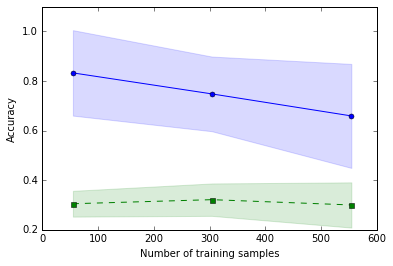

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(train_sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(train_sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(train_sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [65]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=10,
                            random_state=1)

    scores = []
    train_scores=[]
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
    return train_scores,scores



In [66]:
def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        mlp.set_params(alpha= lamda)
        print(mlp.get_params())
        train_s, test_s = crossValidate(mlp,X,y)
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    return np.array(train_scores),np.array(test_scores)

l_range = np.array([0.001,0.003,0.01,0.03,0.1])
train_scores,test_scores = lamda_test(mlp,X,y,l_range)
    

{'beta_1': 0.9, 'random_state': None, 'alpha': 0.001, 'early_stopping': False, 'verbose': 3, 'learning_rate_init': 0.01, 'warm_start': False, 'max_iter': 1000, 'hidden_layer_sizes': (84, 2), 'batch_size': 'auto', 'power_t': 0.5, 'learning_rate': 'adaptive', 'tol': 0.0001, 'beta_2': 0.999, 'validation_fraction': 0.1, 'algorithm': 'l-bfgs', 'momentum': 0.9, 'nesterovs_momentum': True, 'epsilon': 1e-08, 'shuffle': True, 'activation': 'logistic'}
Fold: 1, Class dist.: [137 244 171], Acc: 0.328
Fold: 2, Class dist.: [137 244 172], Acc: 0.381
Fold: 3, Class dist.: [137 245 172], Acc: 0.371
Fold: 4, Class dist.: [138 245 172], Acc: 0.443
Fold: 5, Class dist.: [138 245 172], Acc: 0.197
Fold: 6, Class dist.: [138 245 172], Acc: 0.230
Fold: 7, Class dist.: [138 245 172], Acc: 0.213
Fold: 8, Class dist.: [138 245 172], Acc: 0.459
Fold: 9, Class dist.: [138 245 172], Acc: 0.377
Fold: 10, Class dist.: [138 245 172], Acc: 0.426
lamda: 0.001, train: 0.8000755253917475, test: 0.3424307417969832
{'beta

(5,)
(5,)


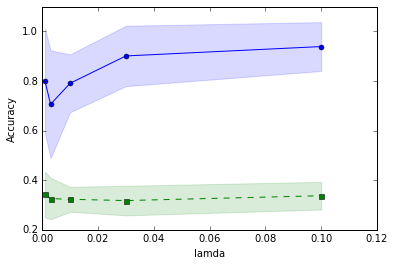

In [69]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean.shape)
print(l_range.shape)
#plotCurve(train_mean,train_std,test_mean,test_std,l_range)
plt.plot(l_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, 
        label='training accuracy')
plt.fill_between(l_range, 
              train_mean + train_std,
               train_mean - train_std, alpha=0.15, color='blue')

plt.plot(l_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(l_range, 
                  test_mean + test_std,
                 test_mean - test_std, 
                alpha=0.15, color='green')
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()
